# Familiarisation avec les données

## Deux types de données
 
**Raster**:

* utilise une matrice de zones carrées, des pixels, dont la taille détermine le détail qui peut être conservé dans le jeu de données
* la valeur d'un pixel peut être continue (ex: altitude) ou catégorielle (ex: utilisation des terres)
* décrit l'intérieur des entitiés cartographiques
* utile pour capturer, stocker et analyser des données qui varient continuellement d'un endroit à l'autre (altitude, température, pH du sol, etc.)

**Vector**:

* utilise des coordonnées _x_ et _y_ pour définir la forme et l'emplacement des zones correspondant aux entités cartographiques
* un vecteur peut être un point (ex: point d'intérêt), une ligne (ex: route) ou un polygone (ex: lac)
* décrit le centre et les bords des entités
* utile pour capturer et stocker des détails spatiaux

https://mapasyst.extension.org/what-is-the-difference-between-raster-and-vector-data/#:~:text=Vector%20data%20are%20excellent%20for,store%20aerial%20and%20satellite%20imagery.

https://carpentries-incubator.github.io/geospatial-python/aio/index.html

## De quelles informations disposons-nous ?

Voir _V. Product description_ du manuel d'utilisation, en particulier _V.I.II. Nomenclature_ et _V.II. CLC status layer products_.

## Exploration des données

In [3]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import shapely
import pandas as pd
from shapely.geometry import mapping
import rioxarray as rxr

### Vector

In [4]:
# clc = gpd.read_file("data/u2018_clc2018_v2020_20u1_geoPackage/DATA/U2018_CLC2018_V2020_20u1.gpkg")

Impossible de lire tout le fichier _.gpkg_ d'un coup car le programme plante. Il faut extraire des zones à l'aide de `QGIS`.


In [5]:
gdf = gpd.read_file("data/france-centre.gpkg")
gdf.head()

,OBJECTID,Code_18,Remark,Area_Ha,ID,geometry
0,458367,111,None,32.684892,EU_458367,"MULTIPOLYGON (((3764057.100 2879442.440, 37638..."
1,464474,112,None,674.856306,EU_464474,"MULTIPOLYGON (((3772518.090 2869459.160, 37724..."
2,464486,112,None,125.582284,EU_464486,"MULTIPOLYGON (((3751235.850 2867880.030, 37509..."
3,464494,112,None,44.825253,EU_464494,"MULTIPOLYGON (((3753121.110 2869761.200, 37531..."
4,464503,112,None,30.711344,EU_464503,"MULTIPOLYGON (((3749222.430 2870367.950, 37491..."


In [6]:
def preprocessing(gdf):
    # utilisation de l'aire calculée par geopandas
    gdf.Area_Ha = gdf.area/1e4
    gdf.Code_18 = gdf.Code_18.astype(int)
    # pour simplifier la création des graphes
    gdf["Node_ID"] = gdf.index
    # todo : gérer les nodata
    # todo : ajouter les données intéressantes pour le graphe (par ex: gdf.length)
    return gdf

In [7]:
gdf = preprocessing(gdf)
gdf.head()

,OBJECTID,Code_18,Remark,Area_Ha,ID,geometry,Node_ID
0,458367,111,None,32.684892,EU_458367,"MULTIPOLYGON (((3764057.100 2879442.440, 37638...",0
1,464474,112,None,674.856306,EU_464474,"MULTIPOLYGON (((3772518.090 2869459.160, 37724...",1
2,464486,112,None,125.582284,EU_464486,"MULTIPOLYGON (((3751235.850 2867880.030, 37509...",2
3,464494,112,None,44.825253,EU_464494,"MULTIPOLYGON (((3753121.110 2869761.200, 37531...",3
4,464503,112,None,30.711344,EU_464503,"MULTIPOLYGON (((3749222.430 2870367.950, 37491...",4


In [8]:
gdf.to_file('data/france-centre-preprocessed.gpkg', driver='GPKG')

/home/massimo/anaconda3/envs/graph/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [9]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 692 entries, 0 to 691
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   OBJECTID  692 non-null    int64   
 1   Code_18   692 non-null    int64   
 2   Remark    0 non-null      object  
 3   Area_Ha   692 non-null    float64 
 4   ID        692 non-null    object  
 5   geometry  692 non-null    geometry
 6   Node_ID   692 non-null    int64   
dtypes: float64(1), geometry(1), int64(3), object(2)
memory usage: 38.0+ KB


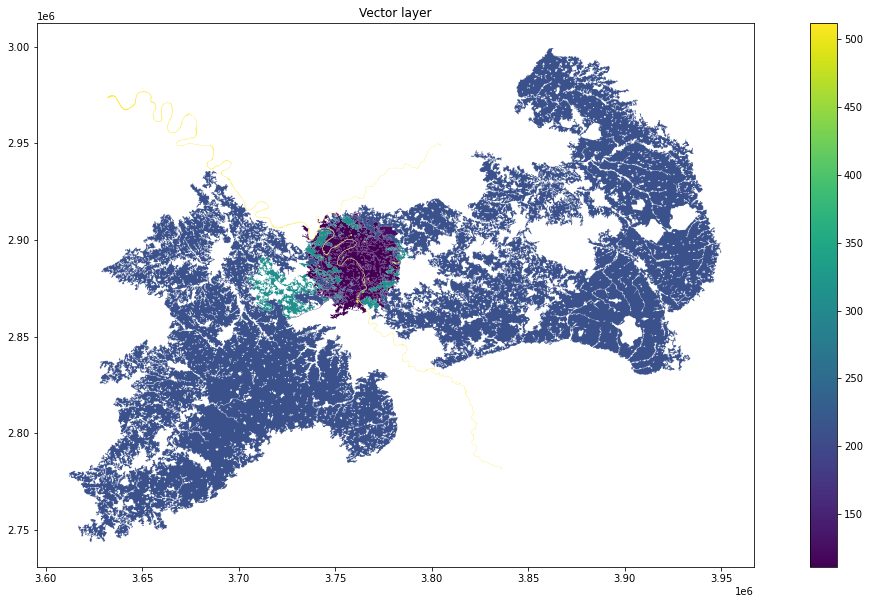

In [10]:
gdf.plot(column="Code_18", legend=True, figsize=(20, 10))
plt.title("Vector layer")
plt.show()

#### Codes

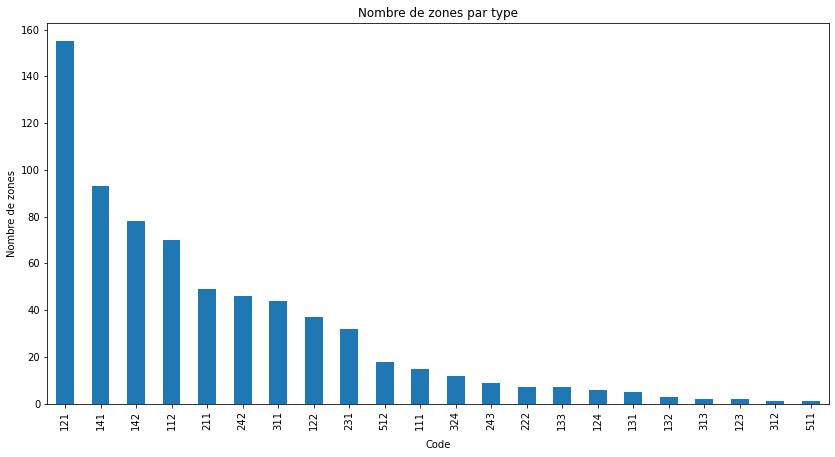

In [11]:
gdf.Code_18.value_counts().plot(kind="bar", figsize=(14, 7))
plt.xlabel("Code",  labelpad=10)
plt.ylabel("Nombre de zones")
plt.title("Nombre de zones par type");

#### Area

In [12]:
gdf.Area_Ha.describe()

count    6.920000e+02
mean     3.730443e+03
std      6.120669e+04
min      2.502368e+01
25%      3.299732e+01
50%      5.519455e+01
75%      1.256282e+02
max      1.140250e+06
Name: Area_Ha, dtype: float64

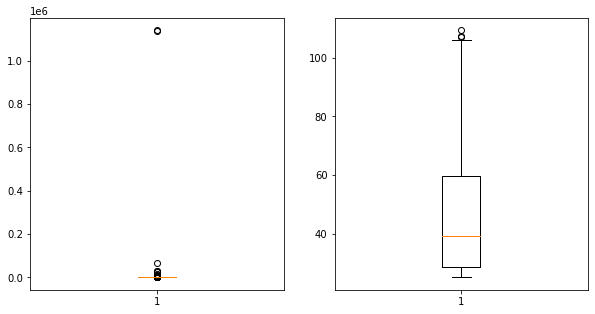

In [13]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.boxplot(gdf.Area_Ha)
plt.subplot(122)
plt.boxplot(gdf.Area_Ha[gdf.Area_Ha < 110])
plt.show()

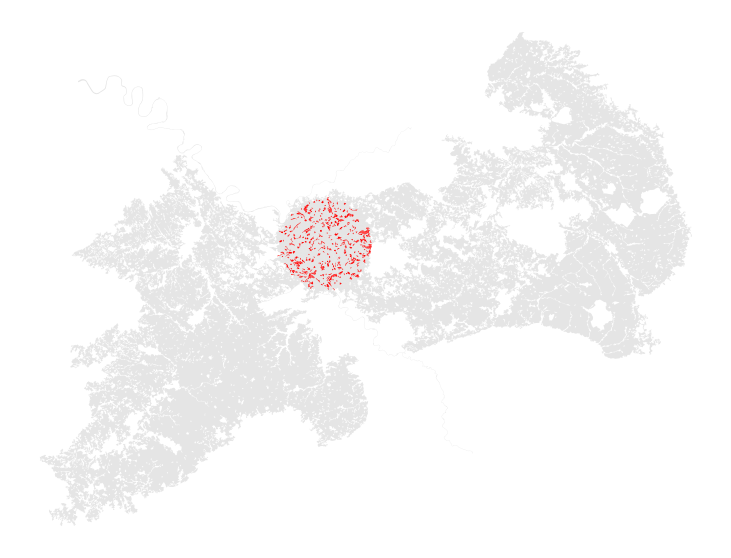

In [14]:
gdf_area_low = gdf[gdf.Area_Ha < 125]
gdf_area_high = gdf[gdf.Area_Ha >= 125]
f, ax = plt.subplots(figsize=(20, 10))
gdf_area_low.plot(ax=ax, color = "red")
gdf_area_high.plot(ax=ax, color="black", alpha = 0.1)
ax.set_axis_off()
plt.show()

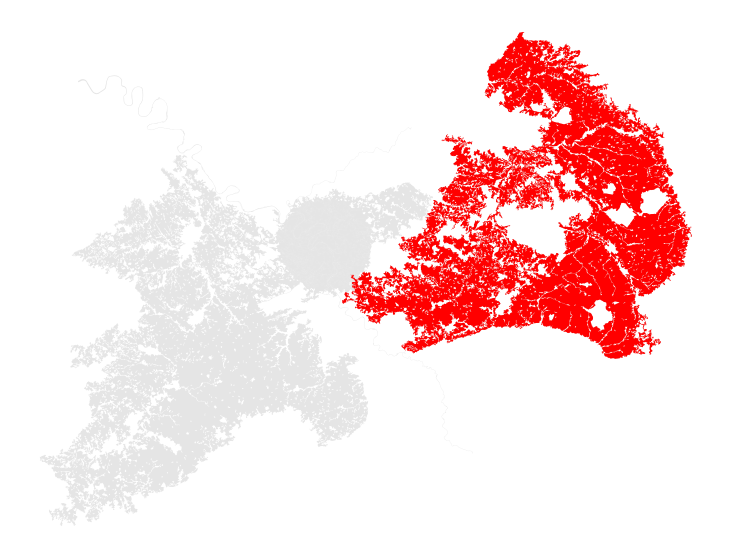

In [15]:
f, ax = plt.subplots(figsize=(20, 10))

gdf.plot(ax=ax, color = "black", alpha = 0.1)
gdf[gdf.Area_Ha == max(gdf.Area_Ha)].plot(ax=ax, color = "red")
ax.set_axis_off()
plt.show()

#### Voisinage

In [16]:
def preprocess_border(area, border):
    overlap = 0
    if border.is_empty:
        return border, overlap
    # overlap
    if border.geom_type == "Polygon" or border.geom_type == "MultiPolygon":
        overlap = 1
        border = border.difference(area.geometry).intersection(area.geometry)
    # plusieurs frontières
    if border.geom_type == "MultiLineString":
        border = shapely.ops.linemerge(border)
    return border, overlap

def calc_borders(area, neighbors):
    borders_info = {"overlap": [], "total_borders":[], "greatest_borders":[], "nb_borders":[]}
    borders = neighbors.geometry.intersection(area.geometry)
    for border in borders:
        border, overlap = preprocess_border(area, border)
        borders_info["overlap"].append(overlap)
        if border.geom_type == "MultiLineString" and not border.is_empty:
            lengths = gpd.GeoSeries(border.geoms).length
            borders_info["total_borders"].append(lengths.sum())
            borders_info["greatest_borders"].append(max(lengths))
            borders_info["nb_borders"].append(len(lengths))
        else:
            length = border.length
            borders_info["total_borders"].append(length)
            borders_info["greatest_borders"].append(length)
            borders_info["nb_borders"].append(1 if length > 0 else 0)
    return borders_info

def calc_neighborhood(gdf):
    neighbors_df = pd.DataFrame(columns=["src", "dest", "overlap", "distance", "total_border", "greatest_border", "nb_border"])

    for index, area in gdf.iterrows():
        print(f"{index}", end="...")

        distances = gdf.geometry.distance(area.geometry)
        # ! prend en compte l'overlapping
        neighbors = gdf[(distances < 10) & (gdf.Node_ID != area.Node_ID)]

        src = np.ones(len(neighbors), dtype=np.int64) * area.Node_ID
        dest = neighbors.Node_ID.tolist()
        distance = distances[neighbors.index].tolist()

        # ! peut avoir plusieurs frontières
        # version 1 : somme des frontières
        # total_borders = neighbors.geometry.intersection(area.geometry).length.tolist()
        # version 2 : la plus grande, la somme et le nombre de frontières
        borders = calc_borders(area, neighbors)

        df = pd.DataFrame({"src":src, "dest": dest, "overlap": borders["overlap"], "distance": distance, "total_border": borders["total_borders"], "greatest_border": borders["greatest_borders"], "nb_border": borders["nb_borders"]})

        neighbors_df = pd.concat([neighbors_df, df])

    print("finished")

    return neighbors_df

In [17]:
neighborhood = calc_neighborhood(gdf)
neighborhood.to_csv("data/france-centre-neighborhood.csv")

0...1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...99...100...101...102...103...104...105...106...107...108...109...110...111...112...113...114...115...116...117...118...119...120...121...122...123...124...125...126...127...128...129...130...131...132...133...134...135...136...137...138...139...140...141...142...143...144...145...146...147...148...149...150...151...152...153...154...155...156...157...158...159...160...161...162...163...164...165...166...167...168...169...170...171...172...173...174...175...176...177...178...179...180...181...182...183...184...

In [39]:
neighborhood.head()

,src,dest,overlap,distance,total_border,greatest_border,nb_border
0,0,56,0,0.0,202.413571,202.413571,1
1,0,662,0,0.0,1851.487084,1851.487084,1
2,0,671,0,0.0,571.23882,571.23882,1
3,0,691,0,0.0,441.460743,441.460743,1
0,1,86,0,0.0,6967.211402,5415.288413,2


In [40]:
neighborhood[neighborhood.overlap == 1]

,src,dest,overlap,distance,total_border,greatest_border,nb_border


Il ne semble pas y avoir de surfaces qui se superposent dans ce jeu de données.

In [41]:
neighborhood.loc[:,"distance":"nb_border"].describe()

,distance,total_border,greatest_border,nb_border
count,3152.0,3152.0,3152.0,3152
unique,2.0,2250.0,2263.0,10
top,0.0,0.0,0.0,1
freq,3150.0,22.0,22.0,2784


In [42]:
neighborhood[neighborhood.distance > 0]

,src,dest,overlap,distance,total_border,greatest_border,nb_border
1,391,462,0,1.724094,0.0,0.0,0
1,462,391,0,1.724094,0.0,0.0,0


Il semble y avoir un couple de voisins légèrement éloignés, mais il faut vérifier qu'ils sont effectivement voisins en vérifiant qu'il n'y a pas un autre terrain entre les deux par exemple.

<AxesSubplot:>

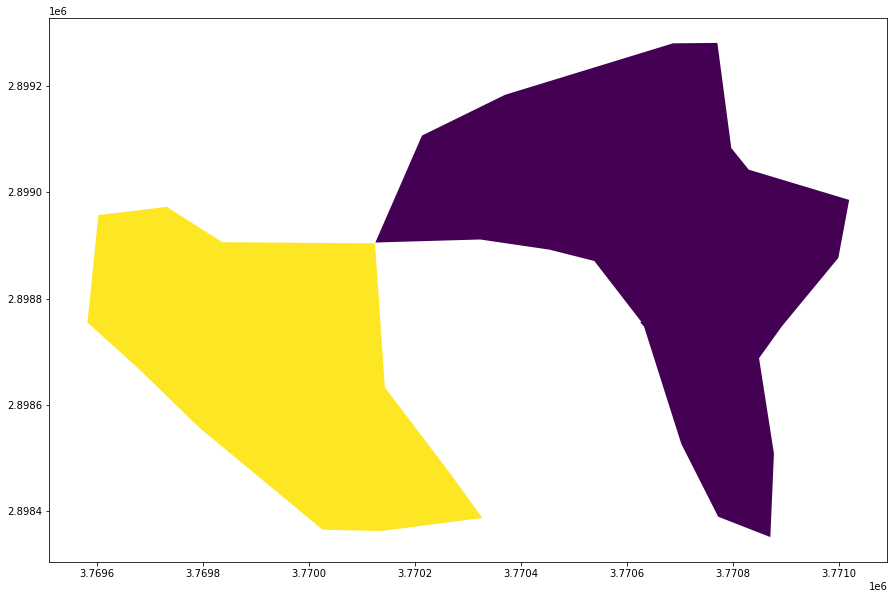

In [43]:
distanced_neighbors = neighborhood[neighborhood.distance > 0].src.tolist()
df = gdf[gdf.Node_ID.isin(distanced_neighbors)]
df.plot("Node_ID", figsize=(20, 10))

<AxesSubplot:>

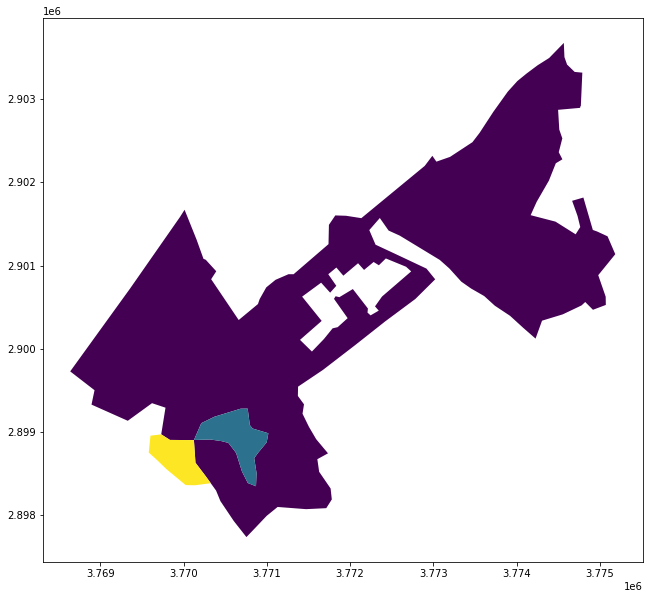

In [44]:
neighbors_391 = neighborhood[neighborhood.src == 391].dest.tolist()
df = gdf[gdf.Node_ID.isin(neighbors_391 + [391])]
df.plot("Node_ID", figsize=(20, 10))

Les surfaces sont très légèrement éloignées mais elles sont séparées par une autre surface. Il faudrait calculer le voisinage sur d'autre zones pour voir si le phénomène se reproduit. Il s'agit néanmoins de l'unique cas où le phénomène apparaît sur 692 instances.

Il faudra calculer le voisinage pour plusieurs zones du jeu complet afin de voir si des voisins légèrement distants ou qui se superposent sont présents. S'il n'y en a pas, alors on pourra limiter le calcul des voisins aux surfaces qui se touchent (`gdf.touches()`), ce qui réduira le temps de calcul.

### Raster

In [45]:
attributes = gpd.read_file("data/clc/u2018_clc2018_v2020_20u1_raster100m/DATA/U2018_CLC2018_V2020_20u1.tif.vat.dbf")
attributes

,Value,Count,LABEL3,Red,Green,Blue,CODE_18,geometry
0,1,800699.0,Continuous urban fabric,0.901961,0.000000,0.301961,111,None
1,2,17085234.0,Discontinuous urban fabric,1.000000,0.000000,0.000000,112,None
2,3,3210212.0,Industrial or commercial units,0.800000,0.301961,0.949020,121,None
3,4,414626.0,Road and rail networks and associated land,0.800000,0.000000,0.000000,122,None
4,5,122685.0,Port areas,0.901961,0.800000,0.800000,123,None
5,6,352020.0,Airports,0.901961,0.800000,0.901961,124,None
6,7,820443.0,Mineral extraction sites,0.650980,0.000000,0.800000,131,None
7,8,125373.0,Dump sites,0.650980,0.301961,0.000000,132,None
8,9,201018.0,Construction sites,1.000000,0.301961,1.000000,133,None
9,10,330596.0,Green urban areas,1.000000,0.650980,1.000000,141,None


Les données raster contiennent les attributs rouge, vert et bleu mais pas infrarouge.

Geopandas ne gère pas les données raster, il faut un outil pour les exploiter: `rioxarray`.

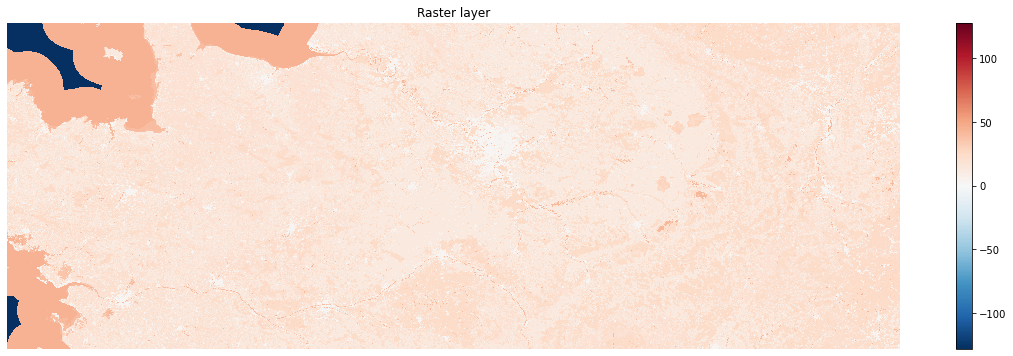

In [46]:
# raster = rxr.open_rasterio('data/france-centre.tif', masked=True).squeeze()
raster = rxr.open_rasterio('data/france-centre.tif').squeeze()

f, ax = plt.subplots(figsize=(20, 6))
raster.plot.imshow(ax=ax)
ax.set(title="Raster layer")
ax.set_axis_off()
plt.show()

**Interrogation**: à quoi servent les autres données (`U2018_CLC2018_V2020_20u1.tif.ovr`, `U2018_CLC2018_V2020_20u1.tfw`...) ?

### Association vector - raster

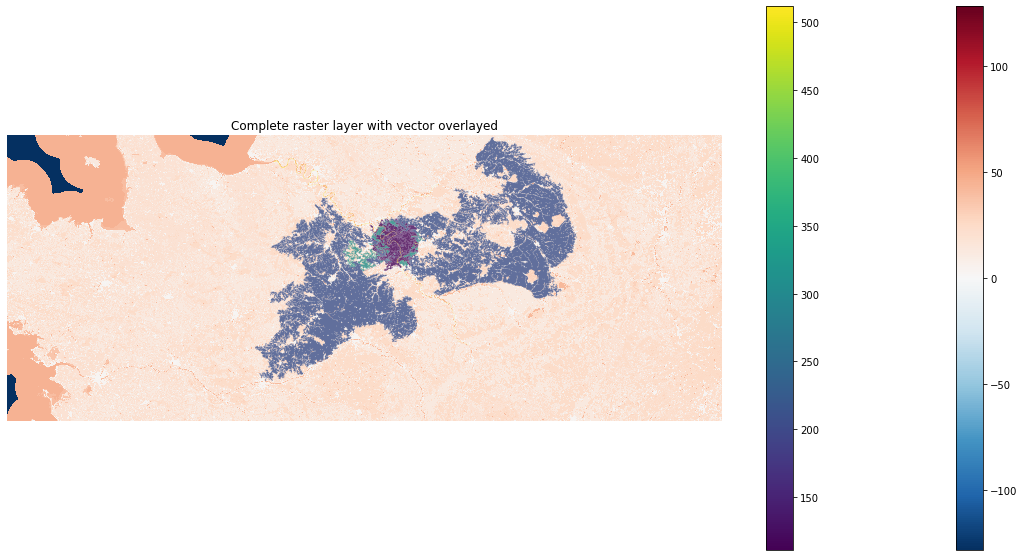

In [47]:
f, ax = plt.subplots(figsize=(20, 10))
raster.plot.imshow(ax=ax)
gdf.plot(column="Code_18", legend=True, ax=ax, alpha=.8)
ax.set(title="Complete raster layer with vector overlayed")
ax.set_axis_off()
plt.show()

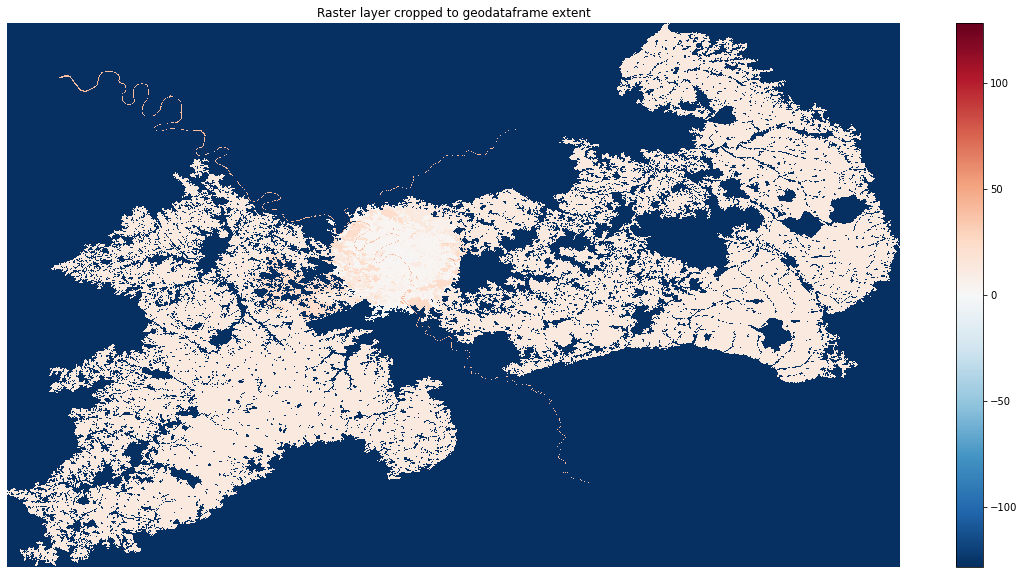

In [48]:
raster_clipped = raster.rio.clip(gdf.geometry.apply(mapping),
                                 # This is needed if your GDF is in a diff CRS than the raster data
                                 gdf.crs)

f, ax = plt.subplots(figsize=(20, 10))
raster_clipped.plot(ax=ax)
ax.set(title="Raster layer cropped to geodataframe extent")
ax.set_axis_off()
plt.show()

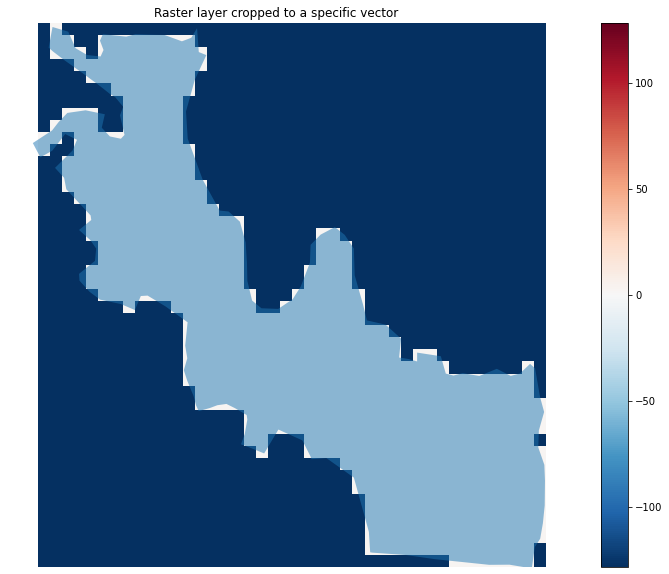

In [49]:
test = raster.rio.clip(gdf.geometry[1].geoms)

f, ax = plt.subplots(figsize=(20, 10))

test.plot.imshow(ax=ax)

gdf.loc[[1], 'geometry'].plot(ax=ax, alpha=.5)

ax.set(title="Raster layer cropped to a specific vector")

ax.set_axis_off()
plt.show()

Les données raster n'ont finalement pas l'air d'ếtre intéressantes à exploiter car on ne dispose pas de données RGB propres à chaque pixel. En effet, il semble que l'on dispose uniquement de valeurs RGB associées de manière générale aux codes CLC.

## Construction du graphe

In [50]:
import dgl
from dgl.data import DGLDataset
import torch
import networkx as nx
import matplotlib.image as mpimg
import os

### Classification de graphe

In [51]:
class GraphClassificationDataset(DGLDataset):
    def __init__(self):
        super().__init__(name='synthetic')

    def process(self):
        gdf = gpd.read_file("data/france-centre-preprocessed.gpkg")
        neighborhood = pd.read_csv("data/france-centre-neighborhood.csv")
        self.labels = []
        self.graphs = []

        neighbors_group = neighborhood.groupby('src')
        for graph_id in neighbors_group.groups:
            print(graph_id, end="...")
            # Find the edges as well as the number of nodes and its label.
            neighbors = neighbors_group.get_group(graph_id)
            num_nodes = len(neighbors) + 1

            nodes_data = gdf[gdf.Node_ID.isin(neighbors.dest.tolist())]
            nodes_data = gpd.GeoDataFrame(pd.concat([gdf[gdf.Node_ID == graph_id], nodes_data]))

            src_nodes = np.zeros(len(neighbors))
            dest_nodes = np.arange(1,num_nodes)

            g = dgl.graph((src_nodes, dest_nodes), num_nodes=num_nodes)
            g.ndata['label'] = torch.from_numpy(nodes_data.OBJECTID.to_numpy())
            g.ndata['area'] = torch.from_numpy(nodes_data.Area_Ha.to_numpy())
            g.ndata['code'] = torch.from_numpy(nodes_data.Code_18.to_numpy())
            g.edata['distance'] = torch.from_numpy(neighbors.distance.to_numpy())
            g.edata['total_border'] = torch.from_numpy(neighbors.total_border.to_numpy())
            g.edata['greatest_border'] = torch.from_numpy(neighbors.greatest_border.to_numpy())
            g.edata['nb_border'] = torch.from_numpy(neighbors.nb_border.to_numpy())

            self.graphs.append(g)
            self.labels.append(nodes_data.iloc[0].OBJECTID)

        # convert the label list to tensor for saving.
        self.labels = torch.LongTensor(self.labels)

        print("finished")

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)

In [52]:
graph_classification_dataset = GraphClassificationDataset()

0...1...2...3...4...5...6...7...8...9...10...11...12...13...14...15...16...17...18...19...20...21...22...23...24...25...26...27...28...29...30...31...32...33...34...35...36...37...38...39...40...41...42...43...44...45...46...47...48...49...50...51...52...53...54...55...56...57...58...59...60...61...62...63...64...65...66...67...68...69...70...71...72...73...74...75...76...77...78...79...80...81...82...83...84...85...86...87...88...89...90...91...92...93...94...95...96...97...98...99...100...101...102...103...104...105...106...107...108...109...110...111...112...113...114...115...116...117...118...119...120...121...122...123...124...125...126...127...128...129...130...131...132...133...134...135...136...137...138...139...140...141...142...143...144...145...146...147...148...149...150...151...152...153...154...155...156...157...158...159...160...161...162...163...164...165...166...167...168...169...170...171...172...173...174...175...176...177...178...179...180...181...182...183...184...

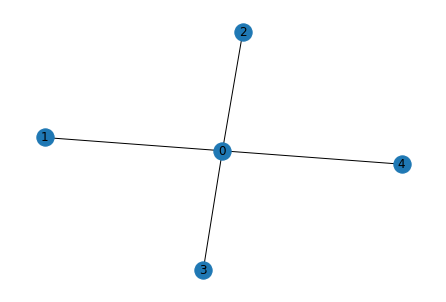

In [53]:
g, label = graph_classification_dataset[0]
g_nx = dgl.to_networkx(g, node_attrs=g.ndata.keys(), edge_attrs=g.edata.keys()).to_undirected()
nx.draw(g_nx, with_labels=True)

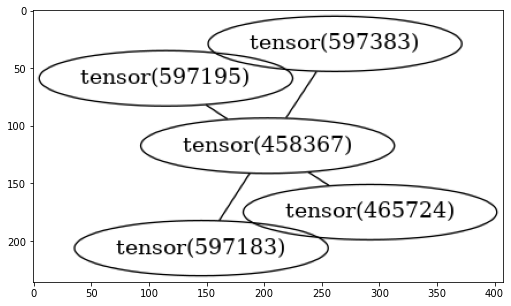

In [54]:
path = './a.out.png'

ag = nx.nx_agraph.to_agraph(g_nx)
ag.layout()
ag.draw(path)

img = mpimg.imread(path)
plt.figure(figsize=(10,5))
plt.imshow(img)
plt.show()

os.remove(path)

In [55]:
# autres exportations
# nx.write_graphml(g_nx, "test.graphml") # peut être utilisé avec cytoscape
# nx.drawing.nx_agraph.write_dot(g_nx, "test.dot") # dot file

### Classification de noeud

In [56]:
class NodeClassificationDataset(DGLDataset):
    def __init__(self):
        super().__init__(name='karate_club')

    def process(self):
        nodes_data = gpd.read_file("data/france-centre-preprocessed.gpkg")
        neighborhood = pd.read_csv("data/france-centre-neighborhood.csv")

        src_nodes = neighborhood.src
        dest_nodes = neighborhood.dest
        num_nodes = nodes_data.shape[0]

        self.graph = dgl.graph((src_nodes, dest_nodes), num_nodes=num_nodes)

        self.graph.ndata['label'] = torch.from_numpy(nodes_data.OBJECTID.to_numpy())
        self.graph.ndata['area'] = torch.from_numpy(nodes_data.Area_Ha.to_numpy())
        self.graph.ndata['code'] = torch.from_numpy(nodes_data.Code_18.to_numpy())
        self.graph.edata['total_border'] = torch.from_numpy(neighborhood.total_border.to_numpy())
        self.graph.edata['greatest_border'] = torch.from_numpy(neighborhood.greatest_border.to_numpy())
        self.graph.edata['nb_border'] = torch.from_numpy(neighborhood.nb_border.to_numpy())

        # masks indicating whether a node belongs to training, validation, and test set
        n_train = int(num_nodes * 0.6)
        n_val = int(num_nodes * 0.2)
        train_mask = torch.zeros(num_nodes, dtype=torch.bool)
        val_mask = torch.zeros(num_nodes, dtype=torch.bool)
        test_mask = torch.zeros(num_nodes, dtype=torch.bool)
        train_mask[:n_train] = True
        val_mask[n_train:n_train + n_val] = True
        test_mask[n_train + n_val:] = True
        self.graph.ndata['train_mask'] = train_mask
        self.graph.ndata['val_mask'] = val_mask
        self.graph.ndata['test_mask'] = test_mask

    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1

In [57]:
node_classification_dataset = NodeClassificationDataset()

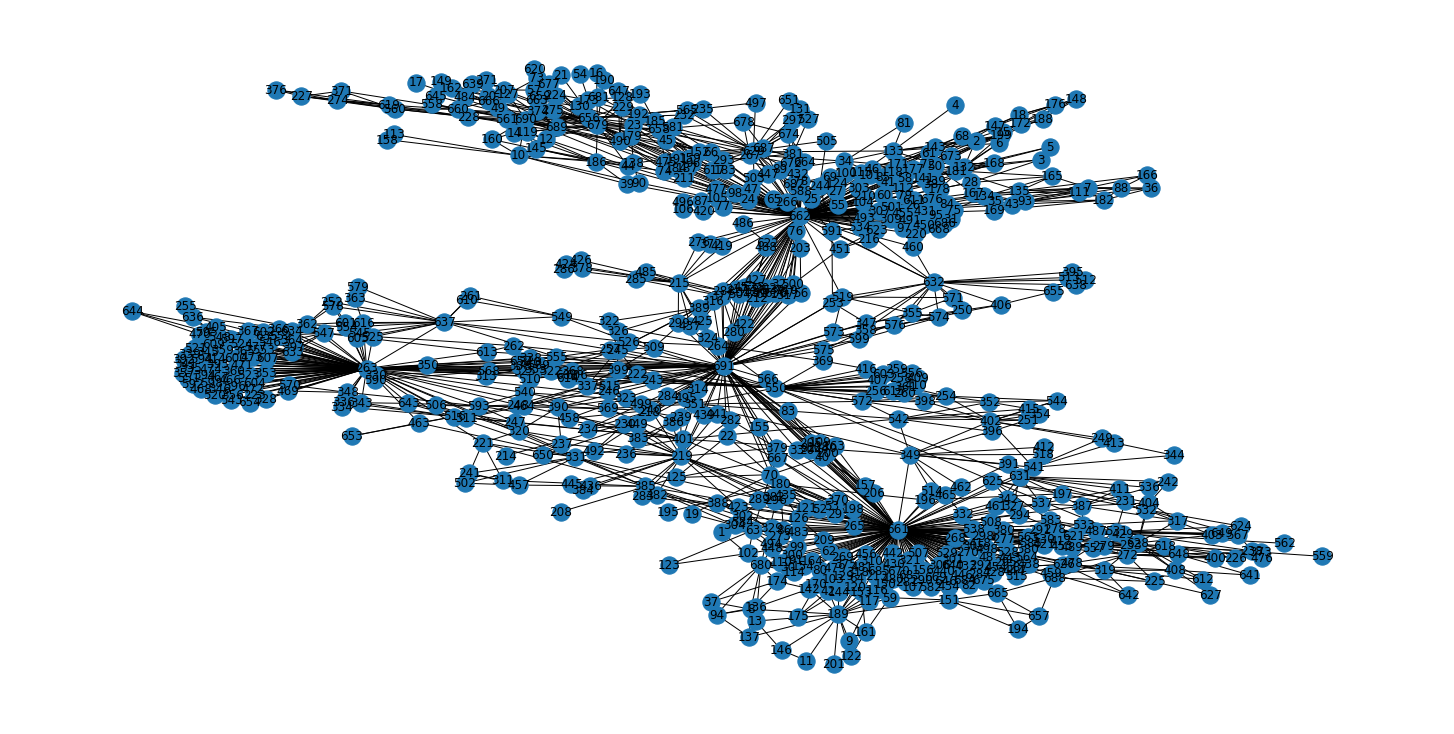

In [58]:
g = node_classification_dataset[0]
plt.figure(figsize=(20,10))
g_nx = dgl.to_networkx(g, node_attrs=g.ndata.keys(), edge_attrs=g.edata.keys()).to_undirected()
nx.draw(g_nx, with_labels=True)